── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘scales’




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor




Rows: 5721444 Columns: 11


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): ride_id, rideable_type, month, start_station_name, end_station_nam...
dbl  (3): duration_min, duration_sec, day_of_week
dttm (2): started_at, ended_at



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ride_id,rideable_type,started_at,ended_at,duration_min,duration_sec,month,day_of_week,start_station_name,end_station_name,member_casual_clean
<chr>,<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
0453E6942013415B,electric_scooter,2024-09-15 13:37:53,2024-09-15 13:38:54,1,60,2024-09,1,NA,NA,casual
1BABCF5E1ED788EA,electric_bike,2024-09-15 16:25:48,2024-09-15 16:26:50,1,61,2024-09,1,NA,NA,casual
0193218274AAAA19,electric_bike,2024-09-01 17:16:00,2024-09-01 17:17:03,1,63,2024-09,1,NA,NA,casual
89A6D63103993150,classic_bike,2024-08-25 20:58:42,2024-08-25 20:59:49,1,67,2024-08,1,Stockton Dr & Wrightwood Ave,DuSable Lake Shore Dr & Diversey Pkwy,member
9502A2240A94C31A,electric_bike,2024-03-03 10:19:15,2024-03-03 10:20:22,1,67,2024-03,1,Larrabee St & Division St,Larrabee St & Oak St,member
26FACB8065B73C1A,electric_scooter,2024-09-15 18:21:29,2024-09-15 18:22:38,1,68,2024-09,1,NA,NA,casual


[1] "Duración promedio (min) por tipo de usuario:"


datos_filtrados$member_casual_clean,datos_filtrados$duration_min
<chr>,<dbl>
casual,21.07285
member,11.91249


[1] "Duración mediana (min) por tipo de usuario:"


datos_filtrados$member_casual_clean,datos_filtrados$duration_min
<chr>,<dbl>
casual,12
member,8


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `day_of_week = lubridate::wday(started_at, label = TRUE, abbr =
  FALSE, locale = "en_US")`.
Caused by warning in `Sys.setlocale()`:
! OS reports request to set locale to "en_US" cannot be honored”


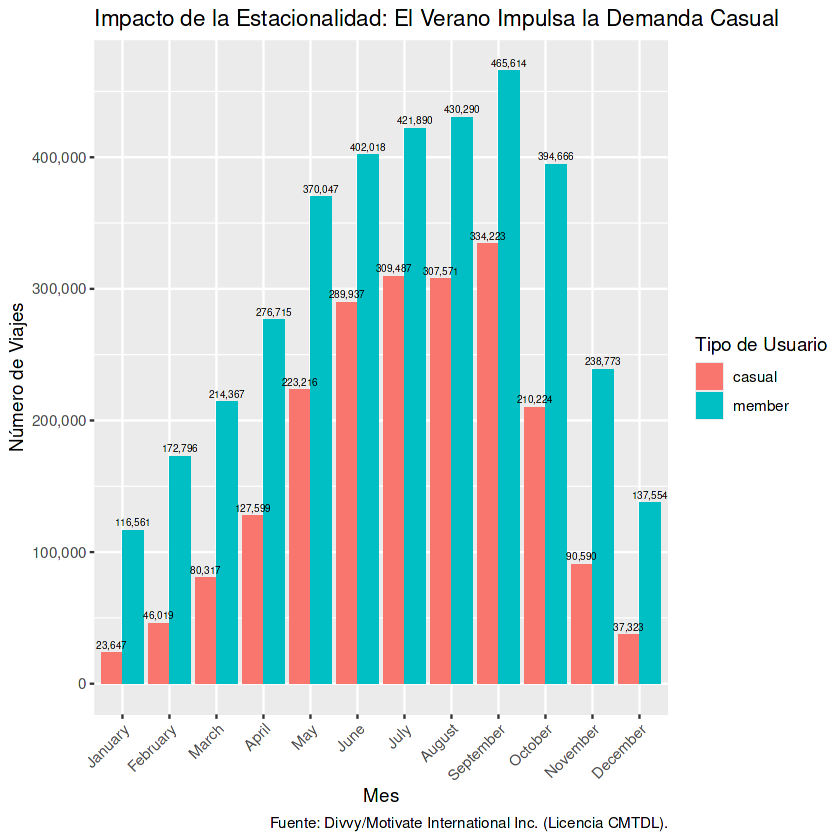

In [ ]:
# -----------------------------------------------------
## 1. CARGAR LIBRERÍAS
# -----------------------------------------------------
library(tidyverse)
library(lubridate)     
library(scales)         

# -----------------------------------------------------
## 2. CARGAR Y FILTRAR DATOS
#El conjunto de datos se consolidó previamente mediante SQL debido a su tamaño (más de 5 millones de registros).
#Este notebook utiliza el conjunto de datos procesado alojado en Kaggle.
# -----------------------------------------------------


ruta_archivo_csv <- "/kaggle/input/trips-processed/trips_processed/trips_processed.csv" 


datos_filtrados <- read_csv(ruta_archivo_csv) %>%   
  filter(duration_min >= 1)
#Se eliminaron viajes de menos de 1 minuto para eliminar posibles valores atípicos o registros no válidos 


# -----------------------------------------------------
## 3. ESTADÍSTICAS DESCRIPTIVAS
# -----------------------------------------------------
# Cálculo de la duración promedio (media) y mediana por tipo de usuario
print("Duración promedio (min) por tipo de usuario:")
aggregate(datos_filtrados$duration_min ~ datos_filtrados$member_casual_clean, FUN = mean)

print("Duración mediana (min) por tipo de usuario:")
aggregate(datos_filtrados$duration_min ~ datos_filtrados$member_casual_clean, FUN = median)


# -----------------------------------------------------
## 4. AGREGACIÓN PRINCIPAL: DÍA DE LA SEMANA Y DURACIÓN
# En esta sección se analiza el volumen de viajes y la duración promedio por día de la semana para identificar diferencias de 
# comportamiento entre los miembros y los pasajeros ocasionales.
# -----------------------------------------------------
# Calcula el volumen de viajes y la duración promedio por día de la semana 
datos_agregados_final <- datos_filtrados %>%
  mutate(day_of_week = lubridate::wday(started_at, label = TRUE, abbr = FALSE, locale = "en_US")) %>%
  mutate(day_of_week = ordered(day_of_week, 
                               levels = c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"))) %>%
  group_by(member_casual_clean, day_of_week) %>%
  summarise(
    numero_de_viajes = n(),
    promedio_duracion = mean(duration_min, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(member_casual_clean, day_of_week)


# -----------------------------------------------------
## 5. VISUALIZACIÓN DE ESTACIONALIDAD (MES)
# -----------------------------------------------------
conteo_mes_usuario <- datos_filtrados %>%
  mutate(mes = lubridate::month(started_at, label = TRUE, abbr = FALSE)) %>% 
  group_by(member_casual_clean, mes) %>%
  summarise(
    numero_de_viajes = n(), 
    .groups = 'drop'
  )

conteo_mes_usuario %>%
  ggplot(aes(x = mes, y = numero_de_viajes, fill = member_casual_clean)) +
  geom_col(position = "dodge") +
  geom_text(
    aes(label = scales::comma(numero_de_viajes)), 
    position = position_dodge(width = 0.9),       
    vjust = -0.5,                                 
    size = 2
  ) +
  scale_y_continuous(labels = scales::comma) +  
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Impacto de la Estacionalidad: El Verano Impulsa la Demanda Casual",
    x = "Mes",
    y = "Número de Viajes",
    fill = "Tipo de Usuario",
    caption = "Fuente: Divvy/Motivate International Inc. (Licencia CMTDL)."
  )

# Nota: Las visualizaciones interactivas finales se desarrollaron en Tableau Public

# -----------------------------------------------------
## 6. EXPORTAR DATOS PARA USO EXTERNO
# -----------------------------------------------------
datos_agregados_final$day_of_week <- recode(datos_agregados_final$day_of_week, 
                                            "Sunday" = "domingo", 
                                            "Monday" = "lunes", 
                                            "Tuesday" = "martes", 
                                            "Wednesday" = "miércoles",
                                            "Thursday" = "jueves", 
                                            "Friday" = "viernes", 
                                            "Saturday" = "sábado")

write.csv(datos_agregados_final, 
          file = './resumen_analisis_ciclistico.csv', 
          row.names = FALSE)
# Exportar datos agregados para herramientas de visualización externas (Tableau)

### Autoría de Datos y Licencia

Este análisis utiliza datos de viajes de bicicletas proporcionados por **Motivate International Inc. (Divvy/Cyclistic)**.

Los datos se utilizan bajo los términos de la **Licencia de Datos de Movilidad y Tránsito del Área Metropolitana de Chicago (CMTDL)**.

**Enlace de la Licencia:** [https://divvybikes.com/data-license-agreement](https://divvybikes.com/data-license-agreement)

## Visualizaciones Finales y Conclusiones (Tableau Public)

Una vez que se generó el archivo de salida (`resumen_analisis_ciclistico.csv`), el análisis se finalizó y visualizó en Tableau Public.

Haga clic en los siguientes enlaces para ver las visualizaciones clave que responden a la pregunta de negocio:

1.  **Comparación de Comportamiento (Viajes por Día):** [https://public.tableau.com/views/AnlisisCiclistico-TomsC_P_/Hoja2?:language=es-ES&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link]
2.  **Duración Promedio de Viaje por Usuario:** [https://public.tableau.com/views/AnlisisCiclistico-TomsC_P_/Hoja1?:language=es-ES&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link]

---

*Nota: Todas las visualizaciones se basan en el archivo de salida `resumen_analisis_ciclistico.csv` generado en la Sección 6.*